In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

import numpy as np
import scipy.signal as sig
import keras
import pandas
import itertools
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras import regularizers
#from keras.models import Model
from keras.models import load_model
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from keras.models import model_from_json



Using TensorFlow backend.


## Load data and Preprocessing

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

# Load data and exclude nan value
data = np.genfromtxt('Livandhandata.txt')
#data1 = np.genfromtxt('Hanfordtestdata.txt')

In [3]:
#####maybe if we cut out the  P waves we can get better results## 
#going to chooose 6000 

#eqgpstime = data[:,0]
#peakgpstime = data[:,24]
#arrivaltime = np.subtract(peakgpstime,eqgpstime)
#distance = data[:,12]
#Velocity = np.divide(distance, arrivaltime)
#pwaveomit = 6000
#Velocity1 = Velocity[Velocity<6000]
#data = data[Velocity<6000]
#print (len(data))

In [4]:


########cutting to only use western hemi data, not needed for IRISwest.txt##########
######side note for sky, refernces w/ [:,] instead of np.array
#print(len(data))
#eq_lon1 =data[:,11]
#print(eq_lon1)
#data = data[(eq_lon1>=-180) & (eq_lon1<=-30)]
#print(len(data))
#########cutting out ocean points ############

#eq_lat2 = data[:,10]
#eq_lon2 = data[:,11]
#map1 = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50, resolution='h')
#lats = eq_lat2  #[:100]                                                                                                        \
                                                                                                                                
#lons = eq_lon2
#x, y = map1(lons, lats)
#locations = np.c_[x, y]
#polygons = [Path(p.boundary) for p in map1.landpolygons]
#result = np.zeros(len(locations), dtype=bool)
#for polygon in polygons:
#    result += np.array(polygon.contains_points(locations))

#eq_lat1=lats[result]
#eq_lon1=lons[result]
#print (len(data))
#print (result)
#data =data[result]
#print (len(data))




In [5]:
# Extract X and y and divide into train, val, and test set
#X = data[:, [2, 11, 12, 13, 14, 15]] #iris   #side note nikils has log10distnace maybe we should try that
X = data[:, [1, 10, 11, 12, 13, 14]] #L10102, H10102, V10102
#side note nikils has log10distnace maybe we should try that
#X = data1[:, [0, 1, 2, 3, 4, 5]] #from Handford test data with log10 distance

#y = np.log10(data[:, 18]) #iris 
#y = np.log10(data[:, 31]) #L10102, H10102, V10102
pre_y = data[:, 31]
z= np.log10(data[:, 25])
# Data preprocessing
# Exclude bad data
#z = np.log10(1e-6)
mask = z > -6.0 #-6.5 #(tri's orig)
#mask = y > 1e-6
#y = y[mask]


#X = X[mask]
#pre_y=pre_y[mask]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(pre_y)
encoded_Y = encoder.transform(pre_y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)




print(y.shape)
print(X.shape)
# Normalizing
X -= np.mean(X, axis=0) #these standard deviations need to be changed if im not doing log?
X /= np.std(X, axis=0)
print(X)

#mean_y = np.mean(y, axis=0)
#stdv_y = np.std(y, axis=0)
#y = (y-mean_y)/stdv_y

# Shuffle and divide into train and val set
mask = np.random.permutation(X.shape[0]) #(does this work with seed)
X = X[mask]
y = y[mask]

print(mask)
#X =X#[:800]
#y=y#[:800]
print(y.shape)
#tfrac = int(0.8*y.size) 
#X_train = X[:tfrac]
#y_train = y[:tfrac]
#X_val = X[tfrac:]
#y_val = y[tfrac:]

#trying to test against all of itself
tfrac = int(0.8*len(y)) 
X_train = X[:tfrac]
y_train = y[:tfrac]
X_val = X[tfrac:]
y_val = y[tfrac:]



print('')
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

(4994, 3)
(4994, 6)
[[-1.15207458 -0.54994645 -1.65391792  0.13979203  1.32576037 -0.58350449]
 [-0.58029264 -0.91145803 -1.68303704  0.3916273   1.41960036 -0.56201709]
 [-0.58029264 -0.4692519  -1.65877111  0.11693588  2.18526824 -0.58427189]
 ...
 [ 5.13752675 -0.0916014   1.00562844  0.02668797  0.24618526 -0.70782444]
 [ 4.75633879  1.81278999  1.1293847  -1.39604936 -0.44723413 -0.50906599]
 [ 5.89990267 -0.96633033 -0.81593433 -0.03447433 -0.3525637   1.48542516]]
[ 651 3498 3315 ...  537 1220 4271]
(4994, 3)

X_train shape: (3995, 6)
y_train shape: (3995, 3)
X_val shape: (999, 6)
y_val shape: (999, 3)


## Create a DENSE network

In [6]:
def Classifier():

# define QuakeNet
    def QuakeNet(input_dim=6, lr=1e-5, reg=0.1, dropout=0.2):
    # create model
        model = Sequential()
        model.add(Dense(256, input_dim=input_dim, activation='relu'))
        model.add(Dense(128, input_dim=input_dim , activation='relu'))
        model.add(Dense(128, input_dim=input_dim, activation='relu'))
        model.add(Dense(32, input_dim=input_dim, activation='relu'))
        model.add(Dense(8, input_dim=input_dim, activation='relu'))
        model.add(Dense(3, activation='softmax'))
    # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model
        print (model.summary())
    model = KerasClassifier(build_fn=QuakeNet, epochs=1000, batch_size=64, verbose=0)
    return model
#model.summary()

In [7]:
#input_shape = (X_train.shape[1], )
model = Classifier()
#model.summary()

In [8]:
'''def QuakeNet(input_shape, lr=1e-3, reg=0.00, dropout=0.5):
      #orig (input_shape, lr=1e-3, reg=0.00, dropout=0.0)
    X_input = Input(input_shape)
    
    X = Dense(8, kernel_regularizer=regularizers.l2(reg),
               activation='relu')(X_input) 
    
    X = Dense(8, kernel_regularizer=regularizers.l2(reg),
               activation='relu')(X) 
    X = Dense(8, kernel_regularizer=regularizers.l2(reg),
               activation='relu')(X)
    X = Dense(8, kernel_regularizer=regularizers.l2(reg),
               activation='relu')(X)
    X = Dense(3,kernel_regularizer=regularizers.l2(reg),
               activation='softmax')(X)       
    
   # X = Dense(2, kernel_regularizer=regularizers.l2(reg),
          #    activation='tanh')(X)
   # X = Dense(8, kernel_regularizer=regularizers.l2(reg),
   #           activation='sigmoid')(X)
   # X = Dense(8, kernel_regularizer=regularizers.l2(reg),
   #           activation='sigmoid')(X)
   # X = Dense(, kernel_regularizer=regularizers.l2(reg),
       #       activation='relu')(X)
    X = Dropout(rate=dropout)(X)
    X = Dense(3, kernel_regularizer=regularizers.l2(reg))(X)

    model = Model(inputs=X_input, outputs=X, name='QuakeNet')
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy')
    
    return model
'''   

"def QuakeNet(input_shape, lr=1e-3, reg=0.00, dropout=0.5):\n      #orig (input_shape, lr=1e-3, reg=0.00, dropout=0.0)\n    X_input = Input(input_shape)\n    \n    X = Dense(8, kernel_regularizer=regularizers.l2(reg),\n               activation='relu')(X_input) \n    \n    X = Dense(8, kernel_regularizer=regularizers.l2(reg),\n               activation='relu')(X) \n    X = Dense(8, kernel_regularizer=regularizers.l2(reg),\n               activation='relu')(X)\n    X = Dense(8, kernel_regularizer=regularizers.l2(reg),\n               activation='relu')(X)\n    X = Dense(3,kernel_regularizer=regularizers.l2(reg),\n               activation='softmax')(X)       \n    \n   # X = Dense(2, kernel_regularizer=regularizers.l2(reg),\n          #    activation='tanh')(X)\n   # X = Dense(8, kernel_regularizer=regularizers.l2(reg),\n   #           activation='sigmoid')(X)\n   # X = Dense(8, kernel_regularizer=regularizers.l2(reg),\n   #           activation='sigmoid')(X)\n   # X = Dense(, kernel_re

In [9]:
#input_shape = (X_train.shape[1], )
#model = QuakeNet(input_shape)
#model.summary()

In [10]:
#To evaluate the model not the predictions

kfold = KFold(n_splits=10, shuffle=True, random_state=7)
results = cross_val_score(model, X_val, y_val, cv=kfold)
print (results)
print(cross_val_score)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.46       0.51       0.46       0.49       0.51000001 0.47
 0.5        0.51       0.46999999 0.48484849]
<function cross_val_score at 0x1c2c4f50d0>
Baseline: 48.65% (1.95%)


## Train

In [11]:
model.fit(X_train, y_train)

## Predict

In [12]:
#model=model.model.save('lockhlv1.hdf5')
#model = load_model('lockhlv1.hdf5')

## serialize model to JSON
#model_json = model.model.to_json()
#with open("lockvir1.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.model.save_weights("lockvir1_weights.h5")
#print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('lockliv1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#load weights into new model
loaded_model.load_weights("lockliv1_weights.h5")
print("Loaded model from disk")


Loaded model from disk


In [13]:
###sky double check this part 
print(y_val)
print(X_val)

y_val2=np.argmax(y_val, axis=1)
y_val=encoder.inverse_transform(y_val2)
print(y_val)


y_pred = model.predict(X_val)
print(y_pred)
print(encoder.inverse_transform(y_pred))



[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[ 0.9444592  -0.32077393  1.10997195  0.50592986 -0.15990107 -0.56892375]
 [-0.58029264  1.30602821  0.06896339  0.17178025 -0.45553856  1.39487112]
 [ 0.75386522 -1.69903685 -1.42258268  0.39459216 -0.45553856 -0.8966066 ]
 ...
 [-0.77088662 -1.09221383 -1.06668232 -0.71669499 -0.45553856 -0.95416214]
 [-1.15207458  0.16339338 -0.83696481 -1.79408888 -0.0253694   1.50537774]
 [-1.15207458  2.2582239  -0.38157412 -1.17545181 -0.46467342  1.26594672]]
[0. 1. 1. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 2. 0. 0. 2. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 2. 0. 1. 2. 1. 0. 2. 0.
 1. 1. 1. 1. 1. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 2. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 2. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 2. 1. 2. 1. 1. 1. 1. 0. 2. 0. 1. 2. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 2. 1. 0. 2. 2. 0. 2. 1. 1. 1. 0. 2. 0. 0. 2. 0.
 0. 1. 1. 1. 0. 1. 2. 1. 2. 

/anaconda3/envs/ligo/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 2 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 2 2 0 1 0 0 0 0 0 0 1
 0 0 1 1 1 2 1 0 0 0 0 1 1 1 1 1 1 0 1 0 2 0 1 1 0 0 1 1 0 1 0 2 1 0 1 1 0
 1 1 2 1 0 1 0 2 1 0 0 0 2 0 1 2 0 0 1 0 0 2 2 0 0 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 2 1 2 2 0 1 1 1 1 2 1 0 0 0 0 2 0 0 0 1 1 0 0 1 0 0 0
 2 1 0 0 1 2 1 1 0 0 0 1 1 0 1 0 2 0 0 0 1 0 1 1 1 2 0 0 1 0 0 0 1 0 0 2 0
 1 2 2 0 1 2 1 2 1 1 1 0 2 0 2 1 1 1 0 0 0 1 0 0 1 0 0 0 2 1 1 1 1 1 2 0 2
 0 0 2 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 2 1 1 2 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 0 1 2 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 2 0 0 2 1 1
 1 1 2 1 0 1 0 2 0 0 1 0 2 0 1 1 1 2 1 1 0 0 1 0 1 1 1 0 1 0 0 0 2 1 1 0 1
 0 0 2 0 0 1 1 0 1 0 0 0 2 0 0 2 1 1 1 1 0 2 0 1 0 1 0 0 2 1 0 0 1 1 1 0 1
 2 1 0 0 2 1 0 0 2 0 0 0 0 0 1 1 1 0 0 1 2 0 2 0 1 1 1 1 2 2 0 1 0 0 0 1 0
 1 0 0 1 0 1 0 1 0 1 1 1 2 1 1 0 2 1 0 0 2 1 1 0 1 2 0 1 0 2 0 1 1 1 1 2 1
 1 0 0 1 1 0 0 1 1 0 0 1 1 2 1 2 0 0 0 2 1 0 0 0 2 0 1 1 0 1 0 0 0 0 2 0 2
 0 1 0 0 0 2 0 0 0 0 2 0 

/anaconda3/envs/ligo/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[274 170  70]
 [128 168  41]
 [ 61  62  25]]
Normalized confusion matrix
[[0.53 0.33 0.14]
 [0.38 0.5  0.12]
 [0.41 0.42 0.17]]


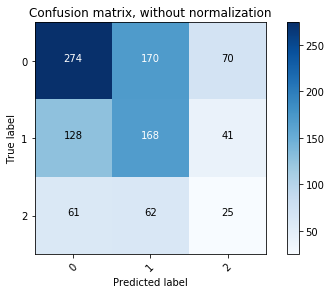

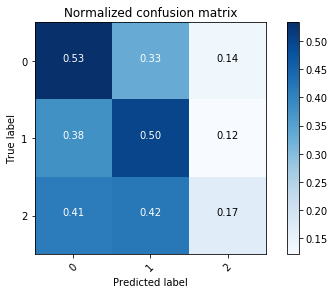

In [14]:
#Confusion_matrix
#pre_y=pre_y[tfrac:]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names=y
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix, without normalization')
plt.savefig('livonhanlockmatrix.png', dpi =300,bbox_inches='tight')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('livonhanlockmatrixN.png', dpi =300,bbox_inches='tight')
plt.show()




In [15]:
#y_pred = model.predict(X_val) # X_val could be new data too?
# Inverse-normalize
#y_val = y_val*stdv_y + mean_y
#y_pred = y_pred*stdv_y + mean_y